In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
from zipfile import ZipFile

file_name = "/content/drive/MyDrive/NavyVessel.zip"


with ZipFile(file_name, 'r') as zip:
  zip.extractall()



```
# This is formatted as code
```



In [4]:
print(len(os.listdir('/content/NavyVessel/Vessel')))

print(len(os.listdir('/content/NavyVessel/No Vessel')))

74
70


In [5]:
try:
    os.mkdir('/content/EnemyNavyVessel')

    os.mkdir('/content/EnemyNavyVessel/training')
    os.mkdir('/content/EnemyNavyVessel/testing')

    os.mkdir('/content/EnemyNavyVessel/training/Ship')
    os.mkdir('/content/EnemyNavyVessel/training/No Ship')


    os.mkdir('/content/EnemyNavyVessel/testing/Ship')
    os.mkdir('/content/EnemyNavyVessel/testing/No Ship')


except OSError:
    pass

In [6]:
import random
from shutil import copyfile


def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)

    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


ENEMYSHIP_SOURCE_DIR = "/content/NavyVessel/Vessel/"
TRAINING_ENEMYSHIP_DIR = "/content/EnemyNavyVessel/training/Ship/"
TESTING_ENEMYSHIP_DIR = "/content/EnemyNavyVessel/testing/Ship/"

NOSHIP_SOURCE_DIR = "/content/NavyVessel/No Vessel/"
TRAINING_NOSHIP_DIR = "/content/EnemyNavyVessel/training/No Ship/"
TESTING_NOSHIP_DIR = "/content/EnemyNavyVessel/testing/No Ship/"

split_size = 0.9

split_data(ENEMYSHIP_SOURCE_DIR,TRAINING_ENEMYSHIP_DIR,TESTING_ENEMYSHIP_DIR, split_size)

split_data(NOSHIP_SOURCE_DIR, TRAINING_NOSHIP_DIR ,TESTING_NOSHIP_DIR , split_size)

In [7]:
TRAINING_DIR = "/content/EnemyNavyVessel/training"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


#  0 - 255 /255 ~ 1 Red to Violet 

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))




VALIDATION_DIR = "/content/EnemyNavyVessel/testing"

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 129 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [9]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 

    tf.keras.layers.Dense(50, activation='relu'),

    tf.keras.layers.Dense(2, activation='softmax')

])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 100)       90100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dropout (Dropout)           (None, 129600)            0

In [10]:
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])


history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=50,
            verbose=1)

#1 0.1 = 0.9 ,  1 0.1 = 0,1

Epoch 1/10
2/2 [==============================] - 15s 4s/step - loss: 11.3694 - acc: 0.4651 - val_loss: 1.9395 - val_acc: 0.5333
Epoch 2/10
2/2 [==============================] - 2s 712ms/step - loss: 1.7277 - acc: 0.4729 - val_loss: 0.6932 - val_acc: 0.4667
Epoch 3/10
2/2 [==============================] - 2s 555ms/step - loss: 0.6932 - acc: 0.4884 - val_loss: 0.6964 - val_acc: 0.4667
Epoch 4/10
2/2 [==============================] - 2s 564ms/step - loss: 0.6993 - acc: 0.4884 - val_loss: 0.7036 - val_acc: 0.4667
Epoch 5/10
2/2 [==============================] - 2s 632ms/step - loss: 0.6963 - acc: 0.4884 - val_loss: 0.6937 - val_acc: 0.4667
Epoch 6/10
2/2 [==============================] - 2s 2s/step - loss: 0.6962 - acc: 0.4884 - val_loss: 0.7044 - val_acc: 0.4667
Epoch 7/10
2/2 [==============================] - 2s 2s/step - loss: 0.6978 - acc: 0.4884 - val_loss: 0.6976 - val_acc: 0.4667
Epoch 8/10
2/2 [==============================] - 2s 2s/step - loss: 0.6933 - acc: 0.4884 - val_l

In [11]:
model.evaluate(validation_generator)

1/1 [==============================] - 0s 252ms/step - loss: 0.6933 - acc: 0.4667


[0.6933467984199524, 0.46666666865348816]

In [12]:
icd = train_generator.class_indices

In [13]:
icd

{'No Ship': 0, 'Ship': 1}

In [14]:
icd = list(icd)

In [15]:
from keras.preprocessing.image import load_img,img_to_array

dic=train_generator.class_indices
#icd={k:v for v,k in dic.items()}

def output(location):

    img=load_img(location,target_size=(150,150,3))
    img=img_to_array(img)

    img=img/255
    
    img=np.expand_dims(img,[0])
    
    answer=model.predict(img)
    ans=answer.tolist()
    ans=list(ans)
    for i in ans:
      temp=i
    ans=temp
    probability=max(ans)
    classes=icd[ans.index(probability)]




    print (classes, 'With probability',probability)



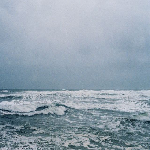

In [16]:
img="/content/NavyVessel/No Vessel/24687d85db71f0004d916d0880e57f34.jpg"
s=load_img(img,target_size=(150,150,3))
s

In [17]:
output(img)

No Ship With probability 0.5014649629592896


In [ ]:
model.save('enemynavyvessel_model.h5')

In [ ]:
model.save_weights("model1.h5") 

In [ ]:
tf.__version__


'2.6.0'